## Load Libraries

In [1]:
import numpy as np
import MDAnalysis as md
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import torch_sgmm, scripts, torch_align
import torch

## Load Trajectory

In [20]:
# point to parameter/topology file and trajectory file
parm_file = "gly5_vac.parm7"
traj_file = "gly5_solv.nvt.stripped.dcd"
# create MD Universe
coord = md.Universe(parm_file,traj_file)
print(coord.trajectory.n_frames)
# make atom selection
sel = coord.select_atoms("all")
# create empty array to contain all selection coordinates
traj_data = np.empty((coord.trajectory.n_frames,sel.n_atoms,3),dtype=np.float64)
# read trajectory and store coordinates (minus COG)
for ts in coord.trajectory:
    traj_data[ts.frame] = sel.positions-sel.center_of_geometry()

30000


## Align Trajectory to single average

In [3]:
usgmm1 = torch_sgmm.ShapeGMMTorch(1,covar_type="uniform",kabsch_thresh=1e-3,dtype=torch.float64,device=torch.device("cpu"),verbose=True)
aligned_traj_usgmm1 = usgmm1.fit(traj_data)

Number of frames being analyzed: 25033
Number of particles being analyzed: 38
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Setting uniform frame weights
Weights from initial clusters in fit: [1.]
1 [1.] -67.642
2 [1.] -67.642


In [21]:
dtype = torch.float64
device = torch.device("cpu")
traj_data_tensor = torch.tensor(traj_data,dtype=dtype,device=device)
torch_align.torch_remove_center_of_geometry(traj_data_tensor,dtype=dtype,device=device)
aligned_traj_tensor, avg_tensor = torch_align.torch_iterative_align_uniform(traj_data_tensor,dtype=dtype,device=device,verbose=True)[:2]

-69.08072824246365
-67.37220802923017
-67.35432897455098
-67.35396346661578


In [5]:
aligned_traj = aligned_traj_tensor.cpu().numpy()
aligned_avg = avg_tensor.cpu().numpy()
print(np.linalg.norm(aligned_traj_usgmm1-aligned_traj))

2.0773900719946763


## Compute Covariance Matrix

In [22]:
disp = aligned_traj - aligned_avg
disp = disp.reshape(-1,sel.n_atoms*3)
covar = np.dot(disp.T,disp)
covar /= (disp.shape[0]-1)

In [23]:
print(covar.shape)

(114, 114)


In [24]:
# check covariance matrix has a null space of 6
e, v = np.linalg.eigh(covar)
print(e[:10])

[-1.08365076e-15 -3.21932731e-16 -2.11606493e-16 -1.27665576e-16
  1.26262893e-16  5.96477928e-16  3.44863953e-04  3.52116748e-04
  3.73983977e-04  3.91858850e-04]


In [25]:
np.savetxt("gly5_uniform_covar.dat",covar)

In [26]:
np.savetxt("gly5_uniform_avg.dat", aligned_avg)

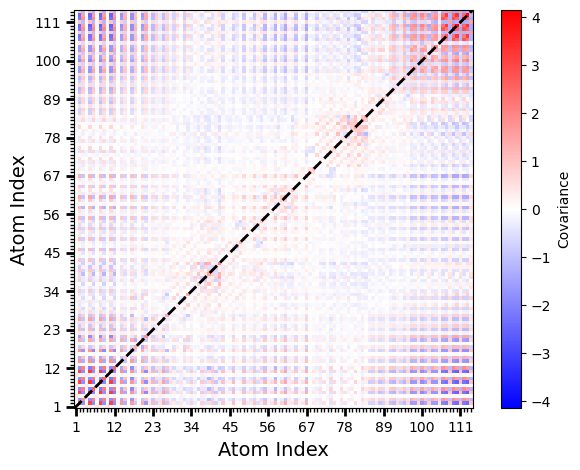

In [27]:
#plot covariance matrix
from matplotlib.ticker import MultipleLocator
plotting_cmap='bwr'
n_nodes = covar.shape[0]
node_range = range(n_nodes+1)
major_ticks = n_nodes//10
minor_ticks = n_nodes//100
fig, ax = plt.subplots()
ax.tick_params(which='major',length=6,width=2)
ax.tick_params(which='minor',length=3,width=1)
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.yaxis.set_major_locator(MultipleLocator(major_ticks))
# make vrange symmetric about zero
v_min = min(np.amin(covar),-np.amax(covar))
v_max = max(np.amax(covar),-np.amin(covar))
temp = plt.pcolormesh(node_range,node_range,covar,cmap=plotting_cmap,vmin=v_min,vmax=v_max)

cb1 = plt.colorbar()
cb1.set_label(r'%s'%("Covariance"))

xlabels = [str(int(x)+1) for x in temp.axes.get_xticks()[:]]
ylabels = [str(int(y)+1) for y in temp.axes.get_yticks()[:]]
temp.axes.set_xticks(temp.axes.get_xticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_xticks(temp.axes.get_xticks()[:]+0.5)
temp.axes.set_yticks(temp.axes.get_yticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_yticks(temp.axes.get_yticks()[:]+0.5)
temp.axes.set_xticklabels(xlabels)
temp.axes.set_yticklabels(ylabels)

plt.xlim((0,n_nodes))
plt.ylim((0,n_nodes))
plt.xlabel("Atom Index",size=14)
plt.ylabel("Atom Index",size=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.plot(np.arange(0,n_nodes,0.01),np.arange(0,n_nodes,0.01),'--',lw=2,color='k')
plt.show();

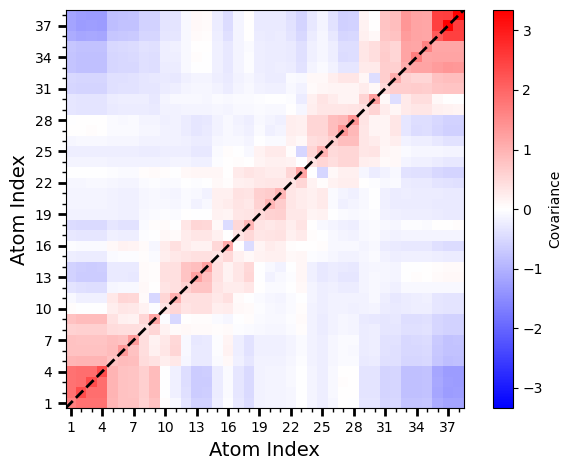

In [28]:
#plot NxN covariance matrix
disp = aligned_traj - avg_tensor.cpu().numpy()
disp = np.transpose(disp,(1,0,2))
disp = disp.reshape(-1,disp.shape[1]*disp.shape[2])
covarN = np.dot(disp,disp.T)
covarN /= (3*(aligned_traj.shape[0]-1))

from matplotlib.ticker import MultipleLocator
plotting_cmap='bwr'
n_nodes = covarN.shape[0]
node_range = range(n_nodes+1)
major_ticks = n_nodes//10
minor_ticks = n_nodes//20
fig, ax = plt.subplots()
ax.tick_params(which='major',length=6,width=2)
ax.tick_params(which='minor',length=3,width=1)
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.yaxis.set_major_locator(MultipleLocator(major_ticks))
# make vrange symmetric about zero
v_min = min(np.amin(covarN),-np.amax(covarN))
v_max = max(np.amax(covarN),-np.amin(covarN))
temp = plt.pcolormesh(node_range,node_range,covarN,cmap=plotting_cmap,vmin=v_min,vmax=v_max)

cb1 = plt.colorbar()
cb1.set_label(r'%s'%("Covariance"))

xlabels = [str(int(x)+1) for x in temp.axes.get_xticks()[:]]
ylabels = [str(int(y)+1) for y in temp.axes.get_yticks()[:]]
temp.axes.set_xticks(temp.axes.get_xticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_xticks(temp.axes.get_xticks()[:]+0.5)
temp.axes.set_yticks(temp.axes.get_yticks(minor=True)[:]+0.5,minor=True)
temp.axes.set_yticks(temp.axes.get_yticks()[:]+0.5)
temp.axes.set_xticklabels(xlabels)
temp.axes.set_yticklabels(ylabels)

plt.xlim((0,n_nodes))
plt.ylim((0,n_nodes))
plt.xlabel("Atom Index",size=14)
plt.ylabel("Atom Index",size=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.plot(np.arange(0,n_nodes,0.01),np.arange(0,n_nodes,0.01),'--',lw=2,color='k')
plt.show();

## Perform cluster scan

In [16]:
# define cluster array
cluster_array = np.arange(1,6,1).astype(int)
print(cluster_array)

[1 2 3 4 5]


In [17]:
# perform cluster scan
train, cv = scripts.cross_validate_cluster_scan(traj_data, 24000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=dtype, device=device)

Number of frames to train each model: 24000
Number of frames to predict each model: 1033
Number of training sets: 3
Number of clusters: 5
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1             137.071          73.624
              1               2               1             139.203         293.342
              1               2               2             140.004         313.536
              1               2               3             138.639         183.044
              1               2               4             140.160         153.590
              1               2               5             139.554         273.063
              1               3               1             141.929         267.117
              1               3               2             140.134

In [18]:
np.savetxt("gly5_train.dat",train)
np.savetxt("gly5_cv.dat",cv)

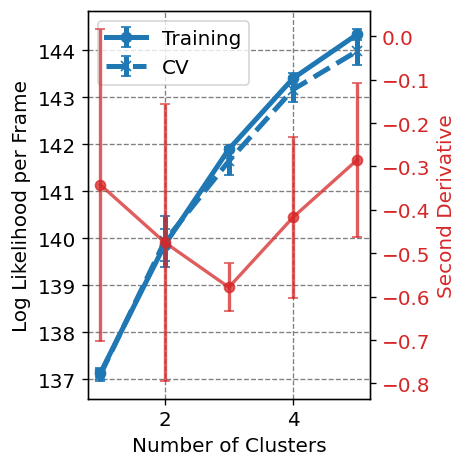

In [19]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
plots.plot_log_likelihood_with_dd(ax,cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()